# Exploring Calcium Imaging Data in Macaque Motor Cortex

This notebook demonstrates how to access and analyze calcium imaging data from non-human primates (macaques) available in Dandiset 001174.

> **⚠️ IMPORTANT**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results. You may need to adjust parameters or approaches based on your specific analysis needs.

## Introduction

This Dandiset (001174) contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor cortex (M1) in rhesus macaques. The researchers used one-photon calcium imaging with miniature microscopes to examine activity patterns of projection neurons while the animals were at rest or engaged in an arm reaching task.

Key aspects of this dataset:

- One-photon calcium imaging in deep layers of motor cortices
- Expression of GCaMP6f to image calcium transients
- Recordings during rest and arm-reaching tasks
- Focus on patterns of neuronal activity and synchronous activation

In this notebook, we will:

1. Access the Dandiset and explore its structure
2. Load calcium imaging data from an NWB file
3. Visualize raw imaging frames and neuron footprints
4. Analyze fluorescence traces and neuronal activity patterns
5. Explore potential correlations between neurons

## Required Packages

You will need the following packages to run this notebook:

- `dandi`: For accessing DANDI archive
- `pynwb`: For working with NWB files
- `lindi`: For remote access to NWB files
- `numpy`: For numerical computations
- `matplotlib`: For visualization
- `scipy`: For signal processing
- `seaborn`: For enhanced visualizations

These should be installed in your environment.

In [1]:
# Import necessary libraries
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal, stats
import seaborn as sns

# Set the visualization style
sns.set_theme()

## Accessing the Dandiset

First, let's use the DANDI API to get information about the Dandiset and list the available assets.

In [2]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

# Getting raw metadata to avoid validation errors
raw_metadata = dandiset.get_raw_metadata()

# Print basic info about the Dandiset
print(f"Dandiset Name: {raw_metadata.get('name', 'N/A')}")
print(f"Dandiset Description: {raw_metadata.get('description', 'N/A')[:300]}...")
print(f"Number of files: {len(assets)}")

Dandiset Name: Calcium imaging in SMA and M1 of macaques
Dandiset Description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We ...
Number of files: 45


Now, let's examine the first few assets to understand what types of files are available in this dataset.

In [3]:
# Display information about the first few assets
print("Sample of available files:")
for asset in assets[:10]:
    print(f"  - {asset.path} ({asset.size/1e9:.2f} GB)")

Sample of available files:
  - sub-V/sub-V_ses-20230309T110929_ophys.nwb (10.66 GB)
  - sub-Q/sub-Q_ophys.nwb (0.79 GB)
  - sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (0.79 GB)
  - sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (1.70 GB)
  - sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (1.56 GB)
  - sub-Q/sub-Q_ses-20221201T132256_ophys.nwb (1.66 GB)
  - sub-Q/sub-Q_ses-20221202T122907_ophys.nwb (1.57 GB)
  - sub-Q/sub-Q_ses-20221206T121002_ophys.nwb (25.12 GB)
  - sub-Q/sub-Q_ses-20220915T133954_ophys.nwb (1.18 GB)
  - sub-Q/sub-Q_ses-20221201T134628_ophys.nwb (0.84 GB)


## Loading an NWB File

For this analysis, we'll focus on a specific NWB file from subject Q during a spontaneous condition recording session. This file contains calcium imaging data from the supplementary motor area (SMA).

In [4]:
# Select an NWB file to work with - we'll use a recording from subject Q
# The URL is constructed based on the asset ID
asset_id = "9c3678d5-22c3-402c-8cd4-6bc38c4d61e3"  # sub-Q_ses-20221003T131952_ophys.nwb
file_url = f"https://lindi.neurosift.org/dandi/dandisets/001174/assets/{asset_id}/nwb.lindi.json"

# Load the NWB file
f = lindi.LindiH5pyFile.from_lindi_file(file_url)
nwb = pynwb.NWBHDF5IO(file=f, mode='r').read()

# Print basic information about this file
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")

Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2022-10-03 13:19:52.708000+00:00
Subject ID: Q
Species: Macaca mulatta
Sex: F
Age: P5Y


## Understanding the Data Structure

Let's explore what types of data are available in this NWB file.

In [5]:
# Print available acquisition data
print("Available acquisition data:")
for name, data in nwb.acquisition.items():
    print(f"  - {name} ({type(data).__name__})")
    if hasattr(data, 'data'):
        print(f"    Shape: {data.data.shape}")
        print(f"    Data type: {data.data.dtype}")
    if hasattr(data, 'rate'):
        print(f"    Rate: {data.rate} Hz")
        
# Print available processing modules
print("\nAvailable processing modules:")
for module_name, module in nwb.processing.items():
    print(f"  - {module_name} ({type(module).__name__})")
    for data_name in module.data_interfaces:
        print(f"    - {data_name}")

Available acquisition data:
  - OnePhotonSeries (OnePhotonSeries)
    Shape: (13107, 320, 200)
    Data type: uint16
    Rate: 10.01 Hz

Available processing modules:
  - ophys (ProcessingModule)
    - EventAmplitude
    - Fluorescence
    - ImageSegmentation


Now we can see that this file contains:

1. Raw calcium imaging data in the `OnePhotonSeries`
2. Processed data including:
   - Fluorescence traces
   - Event amplitudes (detected calcium events) 
   - Image segmentation (neuron footprints/masks)

Let's examine these data in more detail.

In [6]:
# Get the main data components
one_photon_series = nwb.acquisition["OnePhotonSeries"]  # Raw imaging data
fluorescence = nwb.processing['ophys']['Fluorescence']['RoiResponseSeries']  # Extracted fluorescence traces
event_amplitude = nwb.processing['ophys']['EventAmplitude']  # Detected calcium events
plane_seg = nwb.processing['ophys']['ImageSegmentation']['PlaneSegmentation']  # Neuron spatial footprints

# Print details
print(f"One Photon Series: {one_photon_series.data.shape} at {one_photon_series.rate} Hz")
print(f"Fluorescence data: {fluorescence.data.shape} at {fluorescence.rate} Hz")
print(f"Event Amplitude data: {event_amplitude.data.shape}")
print(f"Number of neurons: {plane_seg['image_mask'].data.shape[0]}")
print(f"Image mask shape: {plane_seg['image_mask'].data.shape}")

One Photon Series: (13107, 320, 200) at 10.01 Hz
Fluorescence data: (13107, 18) at 10.01 Hz
Event Amplitude data: (13107, 18)
Number of neurons: 18
Image mask shape: (18, 298, 160)


## Visualizing Raw Calcium Imaging Data

Let's first visualize a frame from the raw calcium imaging data to see what the raw recording looks like.

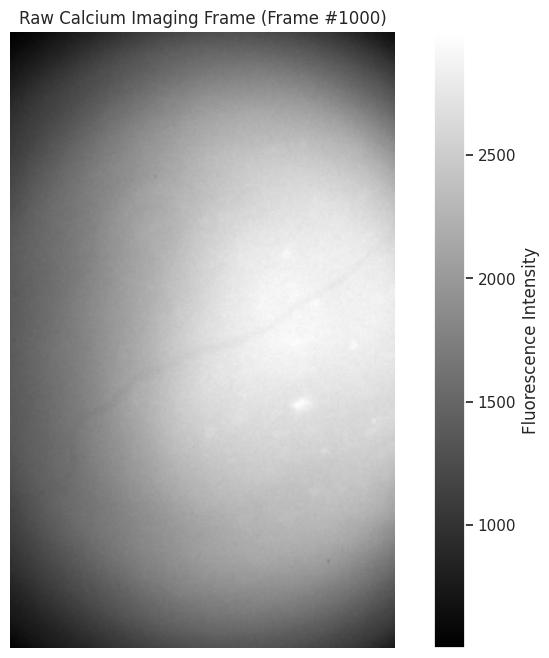

In [7]:
# Extract and visualize a sample frame from the raw calcium imaging data
frame_index = 1000  # Choose a frame to visualize

# Get the sample frame
sample_frame = one_photon_series.data[frame_index]

# Plot the frame
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.colorbar(label='Fluorescence Intensity')
plt.title(f'Raw Calcium Imaging Frame (Frame #{frame_index})')
plt.axis('off')
plt.show()

The image above shows a raw calcium imaging frame from the recording. The brightness in the image corresponds to calcium-dependent fluorescence from neurons expressing GCaMP6f. This one-photon calcium imaging was acquired through microendoscopes implanted in the macaque's motor cortex.

## Visualizing Neuron Spatial Footprints

Next, let's visualize the spatial footprints (masks) of the detected neurons. These masks represent the spatial location and extent of each neuron in the field of view.

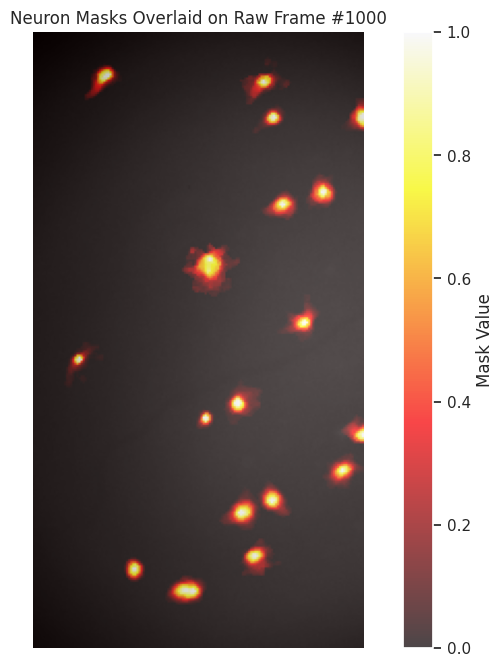

In [8]:
# Get the image masks for the neurons
image_masks = plane_seg['image_mask'].data

# Create a combined mask for visualization
combined_mask = np.zeros(image_masks.shape[1:])
for i in range(image_masks.shape[0]):
    combined_mask = np.maximum(combined_mask, image_masks[i])

# Overlay the neuron masks on the sample frame
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.imshow(combined_mask, alpha=0.7, cmap='hot')
plt.title(f'Neuron Masks Overlaid on Raw Frame #{frame_index}')
plt.colorbar(label='Mask Value')
plt.axis('off')
plt.show()

The image above shows the spatial footprints of all detected neurons overlaid on a raw calcium imaging frame. Each bright spot represents a different neuron. These footprints are used to extract fluorescence time series from the raw imaging data.

Let's look at a few individual neuron masks to better understand their spatial characteristics.

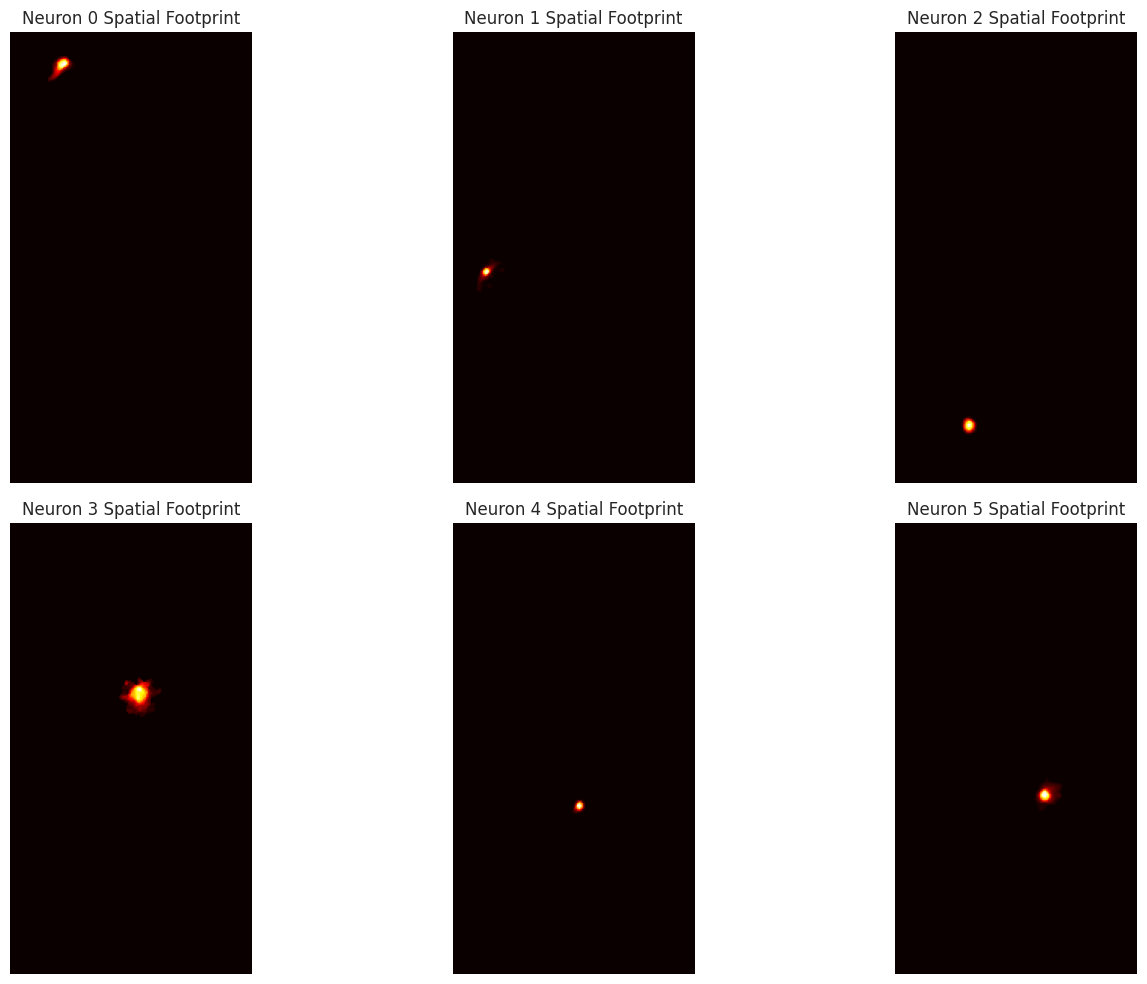

In [9]:
# Plot individual spatial footprints for a few neurons
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, image_masks.shape[0])):
    ax = axes[i]
    mask = image_masks[i]
    ax.imshow(mask, cmap='hot')
    ax.set_title(f'Neuron {i} Spatial Footprint')
    ax.axis('off')

plt.tight_layout()
plt.show()

These plots show the spatial footprints of individual neurons. Each neuron has a distinct, localized spatial footprint with a bright center that corresponds to the cell body (soma). The footprints vary in size, shape, and intensity due to differences in GCaMP expression levels, cell morphology, and imaging conditions.

## Analyzing Fluorescence Traces

Now, let's look at the extracted fluorescence traces, which represent the calcium activity of each neuron over time.

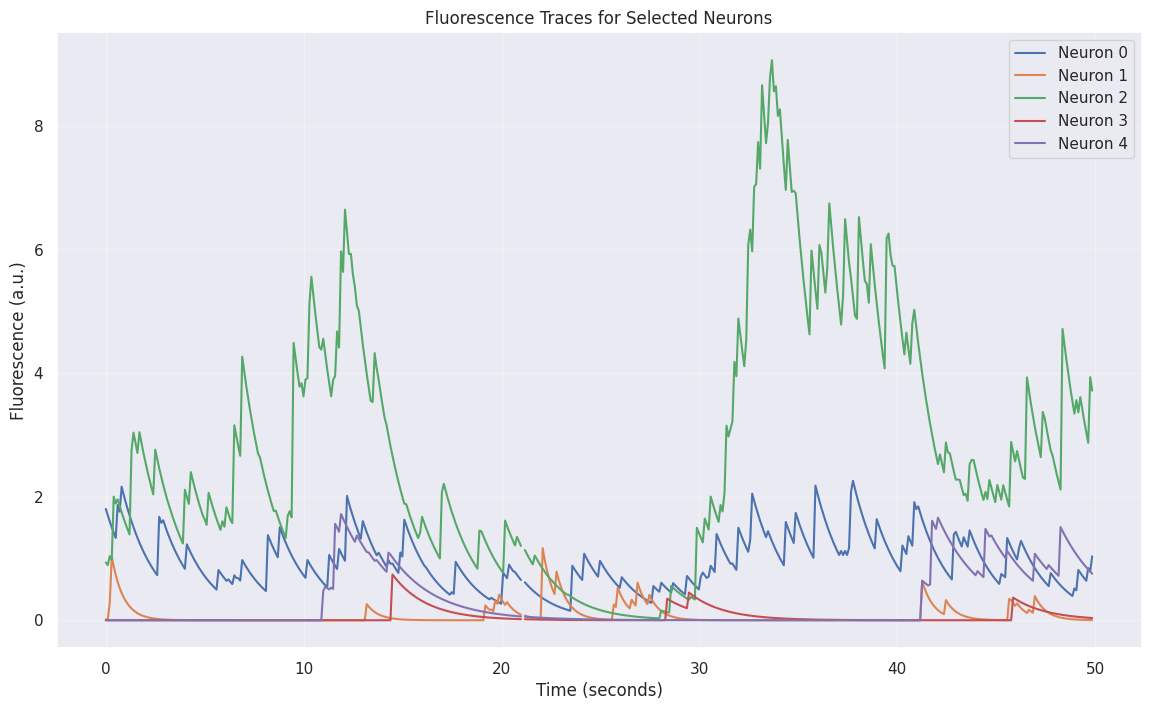

In [10]:
# Get the fluorescence data for a subset of neurons and time
start_frame = 1000
time_window = 500  # frames
neurons_to_plot = min(5, fluorescence.data.shape[1])

# Extract data into a numpy array
fluor_subset = np.array(fluorescence.data[start_frame:start_frame+time_window, :neurons_to_plot])

plt.figure(figsize=(14, 8))

for i in range(neurons_to_plot):
    # Create time points (in seconds)
    time_points = np.arange(time_window) / fluorescence.rate
    
    # Plot the trace
    plt.plot(time_points, fluor_subset[:, i], label=f'Neuron {i}')

plt.xlabel('Time (seconds)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Fluorescence Traces for Selected Neurons')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The plot above shows fluorescence traces for several neurons over time. Each line represents the calcium-dependent activity of a single neuron. Increases in fluorescence correspond to increased intracellular calcium, which is associated with neuronal firing (action potentials).

Key features to notice:

- Calcium transients typically show fast rises followed by slower decays
- Different neurons exhibit distinct activity patterns
- Some periods show coordinated activity across multiple neurons

## Detecting Calcium Events

Let's examine the event amplitude data, which represents detected calcium events (likely corresponding to neuronal firing).

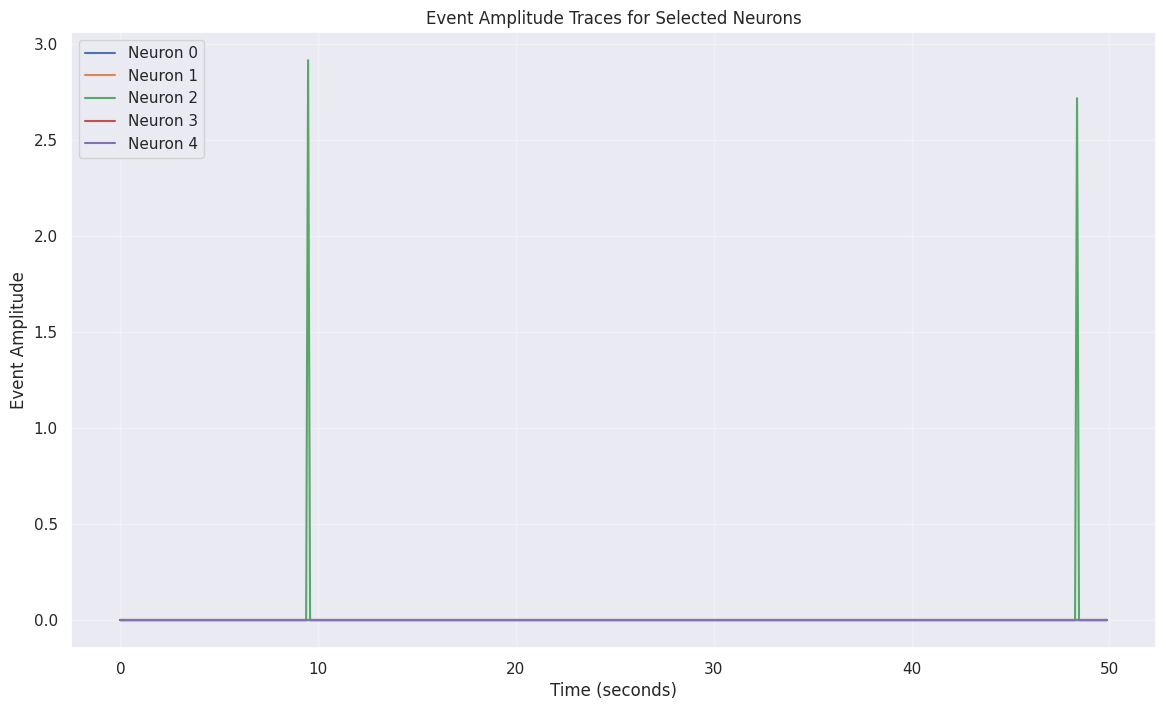

In [11]:
# Extract event amplitude data into a numpy array
events_subset = np.array(event_amplitude.data[start_frame:start_frame+time_window, :neurons_to_plot])

# Plot event amplitude traces for the same neurons and time window
plt.figure(figsize=(14, 8))

for i in range(neurons_to_plot):
    # Create time points (in seconds)
    time_points = np.arange(time_window) / event_amplitude.rate
    
    # Plot the trace
    plt.plot(time_points, events_subset[:, i], label=f'Neuron {i}')

plt.xlabel('Time (seconds)')
plt.ylabel('Event Amplitude')
plt.title('Event Amplitude Traces for Selected Neurons')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

This plot shows the detected calcium events for the same neurons. The event amplitude data is more sparse than the fluorescence traces, as it only captures significant calcium transients that likely correspond to periods of neuronal firing. The amplitude reflects the strength of the detected events.

## Visualizing Population Activity

Now, let's visualize the activity of all neurons together to get a sense of the population dynamics.

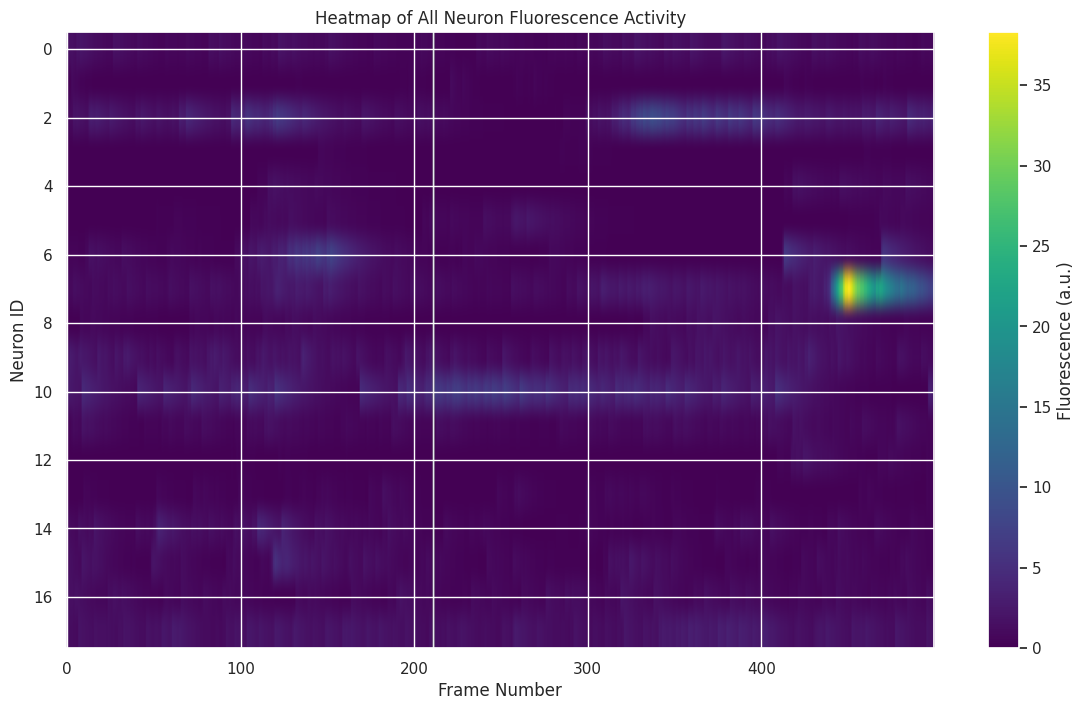

In [12]:
# Create a heatmap of fluorescence activity
plt.figure(figsize=(14, 8))

# Get data for a subset of neurons and time
# We'll use more neurons for the heatmap but keep the same time window
num_neurons = min(18, fluorescence.data.shape[1])  # All neurons if possible
all_traces = np.array(fluorescence.data[start_frame:start_frame+time_window, :num_neurons])

# Create a heatmap
plt.imshow(all_traces.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Fluorescence (a.u.)')
plt.xlabel('Frame Number')
plt.ylabel('Neuron ID')
plt.title('Heatmap of All Neuron Fluorescence Activity')
plt.show()

This heatmap displays the fluorescence activity for all neurons over time. Each row represents a single neuron, and each column represents a time point. The color intensity indicates the fluorescence value, with brighter colors representing higher activity.

## Analyzing Correlations Between Neurons

Let's analyze the correlations between neurons to identify potential functional relationships.

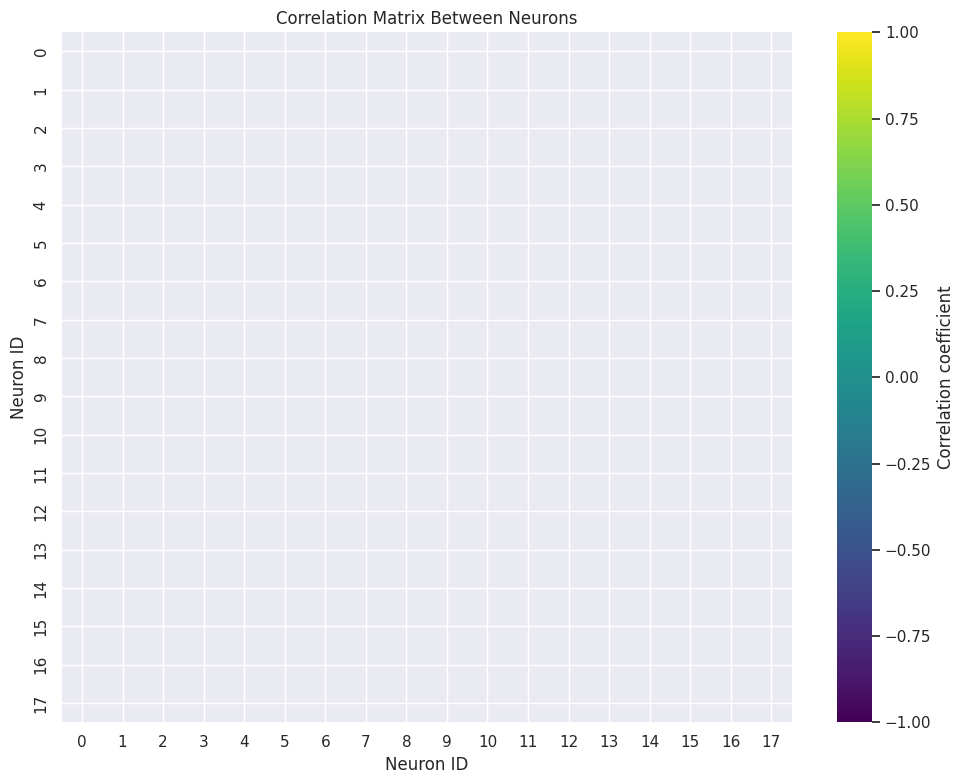

In [13]:
# Compute pairwise correlations between neurons
# Using a subset of the data to make computation faster
subset_length = min(3000, fluorescence.data.shape[0])
subset_data = np.array(fluorescence.data[:subset_length, :])  # Convert to numpy array
corr_matrix = np.corrcoef(subset_data.T)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='viridis', vmin=-1, vmax=1, 
           xticklabels=range(corr_matrix.shape[0]), 
           yticklabels=range(corr_matrix.shape[0]),
           cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix Between Neurons')
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')
plt.tight_layout()
plt.show()

The correlation matrix shows the pairwise correlations between neuron activity patterns. Values close to 1 indicate strong positive correlations (neurons tend to be active together), values close to -1 indicate negative correlations (when one neuron is active, the other tends to be inactive), and values near 0 indicate little correlation.

In this dataset, we can observe that most pairs of neurons show relatively weak correlations, suggesting that during this spontaneous condition they are largely functioning independently rather than in tight synchrony.

## Analyzing Activity Patterns Over Time

Let's examine how many neurons are simultaneously active at different time points.

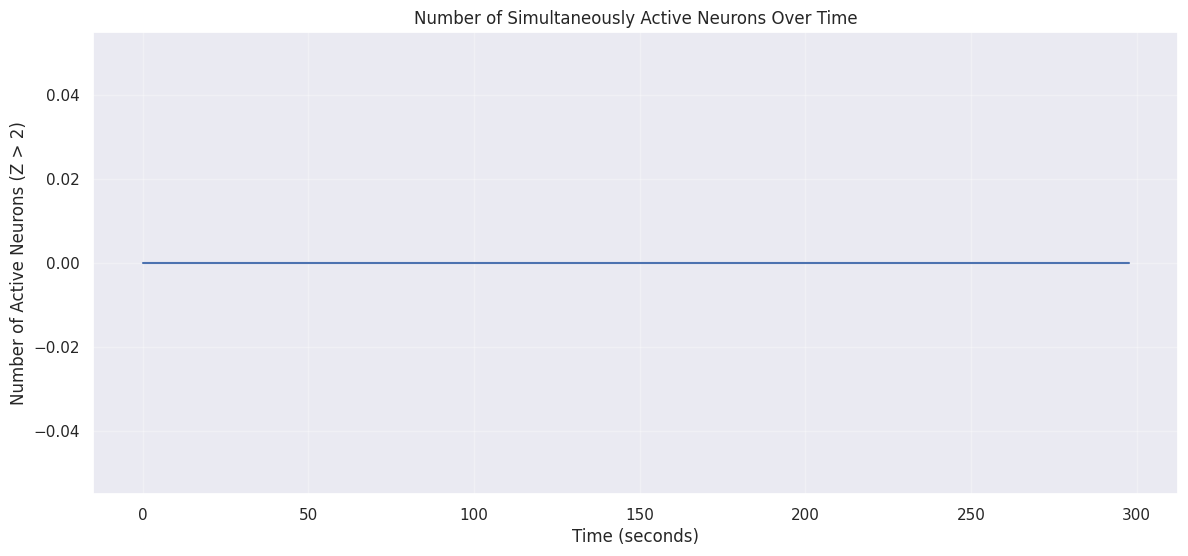

In [14]:
# Define active neurons based on z-scored activity
# First, we need to load the data into memory
# We'll use a subset to avoid memory issues
subset_length = min(3000, fluorescence.data.shape[0])
subset_data = np.array(fluorescence.data[:subset_length, :])  # Convert to numpy array

# Z-score the fluorescence data
z_scored_data = np.zeros_like(subset_data, dtype=np.float32)
for i in range(subset_data.shape[1]):
    neuron_data = subset_data[:, i]
    z_scored_data[:, i] = (neuron_data - np.mean(neuron_data)) / np.std(neuron_data)

# Define active as z-score > 2 (2 std above mean)
active_threshold = 2.0
is_active = z_scored_data > active_threshold
active_count = np.sum(is_active, axis=1)

# Plot number of active neurons over time
# Using a downsampled version for clarity
downsample = 20  # Take every 20th point
time_points = np.arange(0, len(active_count), downsample) / fluorescence.rate
active_count_ds = active_count[::downsample]

plt.figure(figsize=(14, 6))
plt.plot(time_points, active_count_ds)
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Active Neurons (Z > 2)')
plt.title('Number of Simultaneously Active Neurons Over Time')
plt.grid(True, alpha=0.3)
plt.show()

This plot shows the number of neurons that are simultaneously active (defined as having a z-score > 2) at each time point. Peaks in this plot indicate periods of coordinated activity across multiple neurons, which may correspond to specific behavioral or cognitive states.

## Analyzing Frequency Components

Finally, let's perform a spectral analysis to identify any rhythmic patterns in the neural activity.

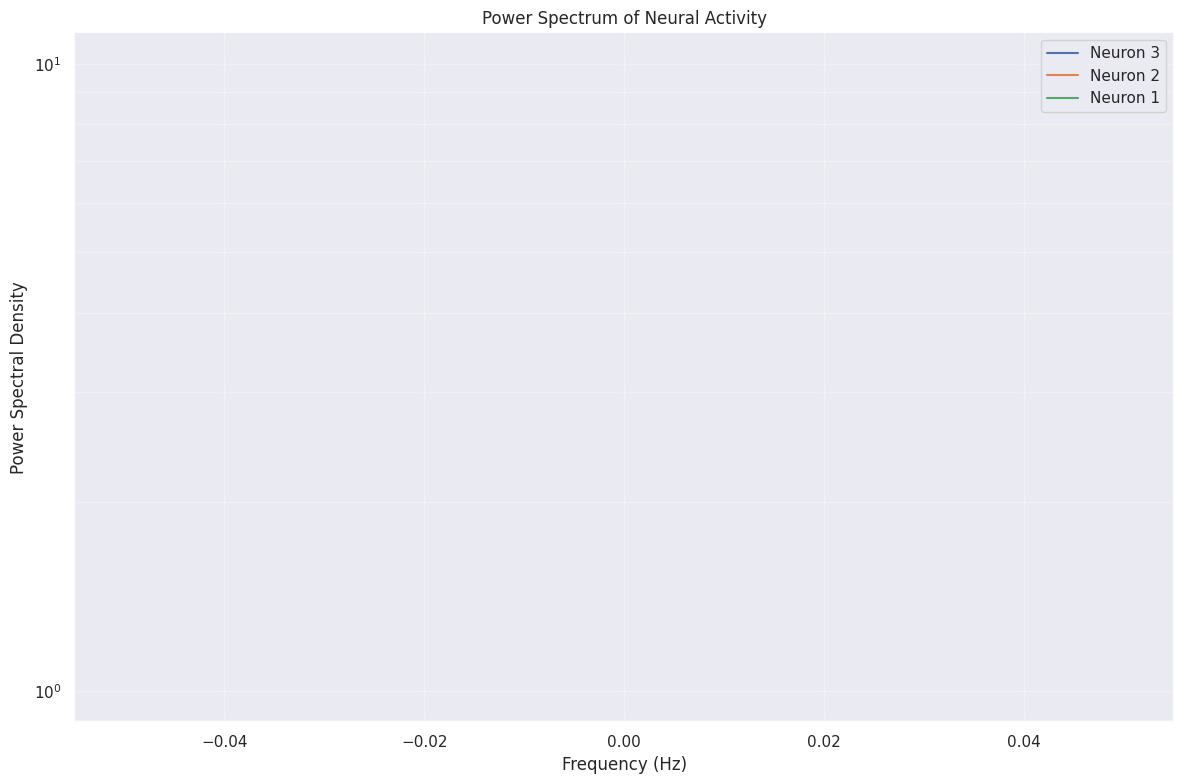

In [15]:
# Choose a few neurons for spectral analysis
# Instead of using the z-scored data from earlier (which is only a subset),
# we'll calculate variability based on the subset_data we already have
neuron_std = np.std(subset_data, axis=0)
most_active_neurons = np.argsort(neuron_std)[-3:]  # Top 3 most variable neurons

plt.figure(figsize=(12, 8))
for i, neuron_id in enumerate(most_active_neurons):
    # Get data for this neuron and normalize it
    neuron_data = subset_data[:, neuron_id]
    normalized_data = (neuron_data - np.mean(neuron_data)) / np.std(neuron_data)
    
    # Compute Power Spectral Density
    freqs, psd = signal.welch(normalized_data, fs=fluorescence.rate, 
                             nperseg=min(1024, len(normalized_data)), 
                             scaling='spectrum')
    
    # Plot only frequencies up to 1 Hz (typical for calcium imaging)
    mask = freqs <= 1.0
    plt.semilogy(freqs[mask], psd[mask], label=f'Neuron {neuron_id}')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectrum of Neural Activity')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

This power spectral density plot shows the frequency components present in the neural activity. Most of the power is concentrated at lower frequencies, which is typical for calcium imaging data due to the slow dynamics of calcium indicators like GCaMP6f. Any peaks in the spectrum could indicate rhythmic activity patterns at specific frequencies.

## Conclusion

In this notebook, we've demonstrated how to access and analyze calcium imaging data from the Dandiset 001174, which contains recordings from macaque motor cortex. We've explored:

1. How to access NWB files from the DANDI archive
2. The structure of calcium imaging data
3. Visualization of raw imaging frames and neuron spatial footprints
4. Analysis of fluorescence traces and calcium events
5. Population-level activity patterns and correlations between neurons

This dataset provides valuable insights into neural activity patterns in primate motor cortices during both spontaneous conditions and motor tasks. The methods demonstrated here can be applied to other calcium imaging datasets as well.

For further exploration, you might consider:

- Comparing activity patterns between rest and task conditions
- Analyzing temporal sequences of neuronal activation
- Relating neural activity to behavioral variables
- Applying more advanced analysis techniques such as dimensionality reduction or encoding models

Remember that this notebook was AI-generated and may need adjustments for your specific research questions.